In [4]:
# uncomment and run the following line if you don't have this package
#!pip install textblob

# Sentiment analysis

In [1]:
import csv
import pandas as pd
import networkx as nx
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import louvain_communities

In [4]:
# data_path = '/content/drive/MyDrive/math168_project/data/08_31.csv'
data_path = '/Volumes/GoogleDrive-105418601834042090131/My Drive/math168_project/data/'

In [5]:
df = pd.read_csv(data_path + '08_11_twitter.csv', dtype="str")

In [6]:
# graph provides information about the author of each edge and if it is a retweet
G = nx.from_pandas_edgelist(df, 'user_screen_name', 'target_user', ['text','user_screen_name','retweet_screen_name'])

## Functions for louvain community

In [7]:
def find_community(G):
    # returns a list of communities, and a filtered list of communities
    
    # if the community is already in the dataset
    if 'Subreddit' in list(G.edges(data=True))[0][2] or 'community' in list(G.edges(data=True))[0][2]:
        filtered_comm = comm = find_dominant_subreddit(G)
    else:
        comm = louvain_communities(G, seed=42)
        # filtering out communities that take up less than 0.01 of the nodes
        filtered_comm = [i for i in comm if len(i) > 0.01*len(G.nodes)]
    return comm, filtered_comm

In [8]:
def daily_louvain_stats(day):
    # returns size of largest and smallest community for the given day
    # and the mean size of communities
    # Note that the communities are filtered to take up at least 0.01 of the nodes
    df = pd.read_csv(data_path + f'08_{day}_twitter.csv', dtype="str")
    G = nx.from_pandas_edgelist(df, 'user_screen_name', 'target_user')
    num = len(G.nodes)
    comm, filtered_comm = find_community(G)
    lengths = np.array([len(i) for i in filtered_comm])
    
    return max(lengths), np.mean(lengths), min(lengths), num



## Sentiment analysis for Twitter

In [9]:
def analyze_sentiment(G):
    # input could be a subgraph or the original graph
    total_polarity = 0.
    for u,v,e in G.edges(data=True):
        # gets the 'text' field for twitter or 'Body' field for reddit
        text = TextBlob(e.get('text', e.get('Body')))
        polarity, subjectivity = text.sentiment
        total_polarity += polarity
#     print(len(G.edges))
    return total_polarity / len(G.edges)

In [10]:
analyze_sentiment(G)
# largest_comm

KeyboardInterrupt: 

In [11]:
def analyze_individiual_sentiments(G, node_names):
    # takes in a list of node names
    total_polarity = 0.
    count = 0
    # if node is not in graph, the following loop has no iterations
    for node_name in node_names:
        for _, _, e in G.edges(node_name, data=True):
            # if the node is the author of the tweet 
            # or tweet is a retweet (in which case both the retweeter and the original tweeter are authors)
            if e.get('user_screen_name', e.get('Author')) == node_name \
            or isinstance(e.get('retweet_screen_name'), str):
                # gets the 'text' field for twitter or 'Body' field for reddit
                text = TextBlob(e.get('text', e.get('Body')))
                polarity, subjectivity = text.sentiment
                total_polarity += polarity
                count += 1
    if count == 0:
        print( G.edges(node_name, data=True)[0])
    return total_polarity / count

### Compare the sentiment of the community and that of the node with the highest "out-degree"

In [12]:
def analyze_community_sentiment(G, id_fn, num_individuals):
    # id_fn is the function that identifies individual nodes in 
    # each community to compare the general sentiment of the community with
    comm, filtered_comm = find_community(G)
    # list of sentiments of the communities and their node with the highest degree
    community_sentiments, individual_sentiments = [], []
    for c in filtered_comm:
        subgraph = G.subgraph(c)
        community_sentiments.append(analyze_sentiment(subgraph))
        individual_nodes = id_fn(subgraph, num_individuals)
        individual_sentiments.append(analyze_individiual_sentiments(subgraph, individual_nodes))
    return community_sentiments, individual_sentiments


In [13]:
from collections import Counter
def highest_out_degree(G, num_individuals):
    counter = Counter([e.get('user_screen_name', e.get('Author')) for _,_,e in G.edges(data=True)])
    names = [i[0] for i in counter.most_common(num_individuals)]
    return names

In [14]:
comm, indiv = analyze_community_sentiment(G, highest_out_degree, 5)

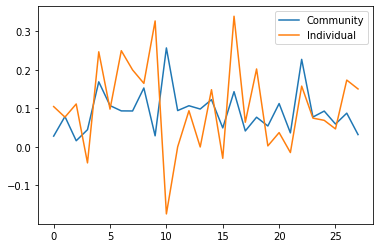

In [88]:
# for only one individual
plt.plot(comm, label='Community')
plt.plot(indiv, label='Individual')
plt.legend()

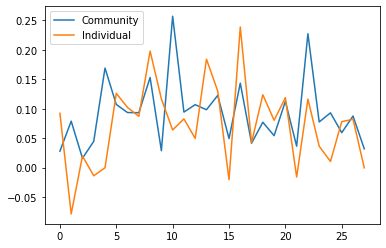

In [16]:
# for five individuals
plt.plot(comm, label='Community')
plt.plot(indiv, label='Individual')
plt.legend()

### Compare the sentiment of the community and that of the node with the highest degree

In [18]:
# faces the issue of the node with highest degree only being retweeted
def highest_degree(G, num_individuals):
    names = [i[0] for i in sorted(G.degree, key=lambda x: x[1], reverse=True)[:num_individuals]]
    return names

In [19]:
comm, indiv1 = analyze_community_sentiment(G, highest_degree, 5)

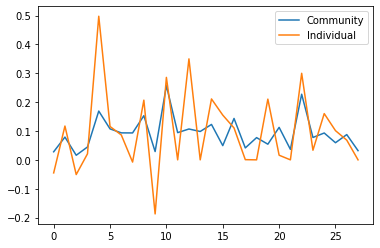

In [122]:
# for one individual
plt.plot(comm, label='Community')
plt.plot(indiv1, label='Individual')
plt.legend()

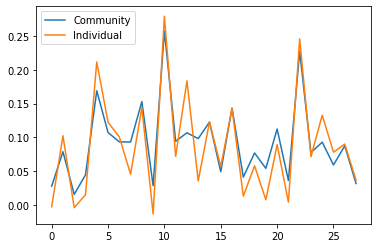

In [20]:
# for five individuals
plt.plot(comm, label='Community')
plt.plot(indiv1, label='Individual')
plt.legend()

### Compare the sentiment of the community and that of the node with the highest betweeness centrality

In [123]:
# faces the issue of the node with highest degree only being retweeted
def highest_centrality(G, num_individuals):
    centralities = nx.betweenness_centrality(G)
    names = [i[0] for i in sorted(centralities.items(), key=lambda x: x[1], reverse=True)[:num_individuals]]
    return names



In [124]:
comm, indiv2 = analyze_community_sentiment(G, highest_centrality, 1)

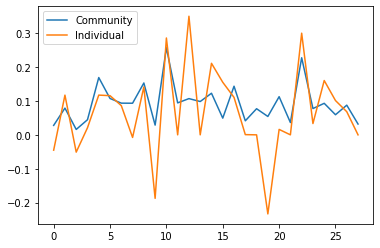

In [125]:
plt.plot(comm, label='Community')
plt.plot(indiv2, label='Individual')
plt.legend()

In [52]:
analyze_sentiment(G.subgraph(largest_comm))

11928


0.01590269198825298

## Sentiment analysis for Reddit

In [2]:
df_reddit = pd.read_csv("https://raw.githubusercontent.com/yuhsin-huang/Math168Project/main/reddit_data.csv")
df_reddit.dropna(subset = ["Parent_Author"], inplace=True)

In [43]:
G = nx.from_pandas_edgelist(df_reddit, create_using = nx.MultiGraph, source = "Author", target = "Parent_Author", 
                            edge_attr = ["ID","Date_utc","Level","Subreddit", "Body", "Author"])
WG = nx.Graph()
for u,v,data in G.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if WG.has_edge(u,v):
        WG[u][v]['weight'] += w
    else:
        WG.add_edge(u, v, weight=w)
    WG[u][v]['ID'] = data['ID']
    WG[u][v]['Level'] = data['Level']
    WG[u][v]['Subreddit'] = data['Subreddit']
    WG[u][v]['Date_utc'] = data["Date_utc"]
    WG[u][v]['Body'] = data['Body']
    WG[u][v]['Author'] = data['Author']

In [4]:
from collections import defaultdict
def find_dominant_subreddit(G):
    nodes = defaultdict(dict)
    for u, v, d in G.edges(data=True):
        subreddit = d['Subreddit']
        old = nodes[u].get(subreddit, 0)
        nodes[u][subreddit] = old+d['weight']
        old = nodes[v].get(subreddit, 0)
        nodes[v][subreddit] =old+d['weight']
    subreddits = defaultdict(set)
    for n, subs in nodes.items():
        top_sub = sorted(subs.items(), key=lambda x:x[1], reverse=True)[0][0]
        subreddits[top_sub].add(n)
    return subreddits.values()

In [68]:
len(find_community(WG)[0])

12

### Degree for Reddit

In [46]:
from collections import Counter
def highest_out_degree_weights(G, num_individuals):
    counter = Counter()
    for _, _, e in G.edges(data=True):
        counter[e['Author']] += e['weight']
    names = [i[0] for i in counter.most_common(num_individuals)]
    return names

In [47]:
comm_reddit, indiv_reddit = analyze_community_sentiment(WG, highest_out_degree_weights, 1)

done
done
done
done
done
done
done
done
done
done
done
done


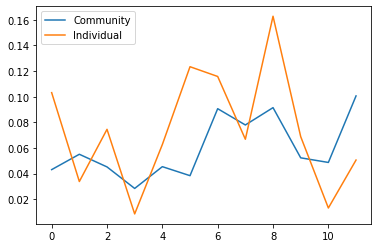

In [48]:
# for one individual
plt.plot(comm_reddit, label='Community')
plt.plot(indiv_reddit, label='Individual')
plt.legend()

In [49]:
comm_reddit, indiv_reddit_5 = analyze_community_sentiment(WG, highest_out_degree_weights, 5)

done
done
done
done
done
done
done
done
done
done
done
done


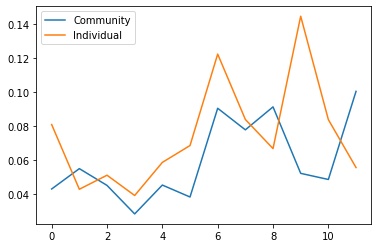

In [56]:
# for five individuals
plt.plot(comm_reddit, label='Community')
plt.plot(indiv_reddit_5, label='Individual')
plt.legend()

### Centrality for Reddit

In [54]:
def highest_centrality_weights(G, num_individuals):
    centralities = nx.betweenness_centrality(G, weight='weight')
    names = [i[0] for i in sorted(centralities.items(), key=lambda x: x[1], reverse=True)[:num_individuals]]
    return names


In [55]:
comm_reddit, indiv_reddit_bet = analyze_community_sentiment(WG, highest_centrality_weights, 5)

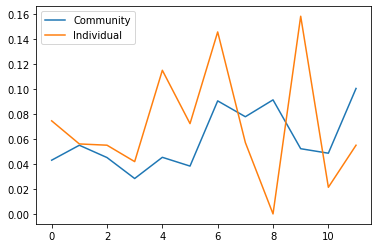

In [57]:
# for five individuals
plt.plot(comm_reddit, label='Community')
plt.plot(indiv_reddit_bet, label='Individual')
plt.legend()